<a href="https://colab.research.google.com/github/alstondu/MAAI_COLAB/blob/main/COMP0124_MAAI_2022_Lab_4_Learning_Nash_Equilibria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP0124 MAAI Lab 4: Learning Nash Equilibria

This lab work has three parts
- Model two-person, zero-sum game as a linear programming problem
- Support enumeration and vertex enumeration to find the Nash Equilibrium of two-person, general-sum game
- The Lemke–Howson algorithm to find the Nash Equilibrium of two-person, general-sum game more efficiently.

## Instructions
1.   To start this notebook, please duplicate this notebook at first:
  - Choose "File => Save a copy in Drive" and open/run it in Colab.
  - Or you can download the notebook and run it in your local jupyter notebook server.
2.   For the coding assignment and practice, please write your code at `### TODO ###` blocks or in a new cell. For analysis report, you are free to use as many blocks as you need.
3. If you have any questions, please contact TAs: [Minne Li](minne.li@cs.ucl.ac.uk), [Oliver Slumbers](o.slumbers@cs.ucl.ac.uk), [Xihan Li](xihan.li@cs.ucl.ac.uk), [Xidong Feng](xidong.feng@cs.ucl.ac.uk), and [Mengyue Yang](m.yang@cs.ucl.ac.uk).

## Part 1: Model two-person, zero-sum game as a linear programming problem

### 1.1 A Primer to Linear Programming

Linear programming is a major type of constrainted optimization that both the objective and constraints are linear. It is formed as

\begin{aligned}
\min ~ c^\top x \\
s.t. Ax = b \\
x \geq 0
\end{aligned}
where matrix  𝐴  and column vectors  𝑏  and  𝑐  are given and  𝑥  is the output.

An example from [Wikipedia](https://en.wikipedia.org/wiki/Linear_programming#Example):

> Suppose that a farmer has a piece of farm land, say $L$ km<sup>2</sup>, to be planted with either wheat or barley or some combination of the two. The farmer has a limited amount of fertilizer, $F$ kilograms, and pesticide, $P$ kilograms. Every square kilometer of wheat requires $F_1$ kilograms of fertilizer and $P_1$ kilograms of pesticide, while every square kilometer of barley requires $F_2$ kilograms of fertilizer and $P_2$ kilograms of pesticide. Let $S_1$ be the selling price of wheat per square kilometer, and $S_2$ be the selling price of barley. If we denote the area of land planted with wheat and barley by $x_1$ and $x_2$ respectively, then profit can be maximized by choosing optimal values for $x_1$ and $x_2$. This problem can be expressed with the following linear programming problem in the standard form:
> \begin{aligned}
\max \quad S_1\cdot x_1+S_2\cdot x_2 & \quad & \text{(maximize the revenue)}\\
\text{Subject to} \quad x_1 + x_2 & \leq L \quad & \text{(limit on total area)} \\
F_1\cdot x_1+F_2\cdot x_2 & \leq F \quad & \text{(limit on fertilizer)} \\
P_1\cdot x_1 + P_2\cdot x_2 & \leq P \quad & \text{(limit on pesticide)} \\
x_1\geq 0, x_2 & \geq 0 \quad & \text{(cannot plant a negative area)}
\end{aligned}

#### Q1: Solve the example LP model via `cvxopt`

Given $L = 50, S_1 = 1.5, S_2 = 2.5, F_1 = 1.0, P_1 = 2.0, F_2 = 4.0, P_2 = 3.0, F = 100, P = 100$, please output the optimal area planted with wheat and berley $x_1$ and $x_2$ so that the revenue is maximal. Here we use `cvxopt` as the [solver](https://en.wikipedia.org/wiki/List_of_optimization_software). That is, you need to transform the above model as a standard matrix form and feed the matrices into `cvxopt`, so that the solver can handle the solving procedure and output the optimal solution of your model.

- [Linear Programming docs of `cvxopt`](https://cvxopt.org/userguide/coneprog.html#linear-programming)

Note: cvxopt uses min as opposed max in their standard LP form.

Tips:

- $\max c^\top x \iff \min -c^T x$
- $Gx + s = h, s \geq 0 \iff Gx \leq h$
- $x \geq 0 \iff -x \leq 0$

In [ ]:
import numpy as np
from cvxopt import matrix, solvers

L = 50.
S_1, S_2 = 1.5, 2.5
F_1, P_1 = 1.0, 2.0
F_2, P_2 = 4.0, 3.0
F = 100.
P = 100.

### TODO: Compute C, G and h for cvxopt (please refer to the above link for the examples of using cvxopt) ###
c = matrix([_, _])
G = matrix(np.array(_))     # should be a 5x2 matrix since we have 5 constraints and 2 variables
h = matrix([_, _, _, _, _])
### END TODO ###
sol = solvers.lp(c, G, h)
print(sol['x'])

c
 [-1.50e+00]
[-2.50e+00]
 G
 [ 1.00e+00  1.00e+00]
[ 1.00e+00  4.00e+00]
[ 2.00e+00  3.00e+00]
[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
 h
 [ 5.00e+01]
[ 1.00e+02]
[ 1.00e+02]
[ 0.00e+00]
[ 0.00e+00]

     pcost       dcost       gap    pres   dres   k/t
 0: -7.7941e+01 -3.7574e+02  7e+01  1e-02  3e+00  1e+00
 1: -7.9058e+01 -9.6418e+01  4e+00  9e-04  2e-01  5e-02
 2: -7.9972e+01 -8.0256e+01  6e-02  1e-05  3e-03  1e-03
 3: -8.0000e+01 -8.0003e+01  6e-04  1e-07  3e-05  1e-05
 4: -8.0000e+01 -8.0000e+01  6e-06  1e-09  3e-07  1e-07
 5: -8.0000e+01 -8.0000e+01  6e-08  1e-11  3e-09  1e-09
Optimal solution found.
[ 2.00e+01]
[ 2.00e+01]



### 1.2 The Minimax Trick

In the field of operational research, there are quite a few tricks that help us transform optimization problems with special non-linear features as conventional linear programming models. A very useful reference can be found [here](https://documentation.aimms.com/_downloads/AIMMS_modeling.pdf) (Chapter 6).

In this section, we introduce the minimax trick, so that we can transform problems with a minimax objective into a valid LP model.

Consider the following model

Minimize $$\max(c_1^\top x, \dots, c_N^\top x)$$

in which the objective to be minimized is "the maximum value in a list of $N$ linear expressions". While the $\max$ function is not linear, we have a trick to transform it to a linear model via introducing an additional variable. To find the maximal value in a list, we are actually finding a value $z$ that is large or equal than all the values in the list, and $z$ should be as small as possible. That is,

Minimize $$z$$

So that

\begin{align}
z &\geq c_1^\top x \\
z &\geq c_2^\top x \\
&\dots \\
z &\geq c_N^\top x \\
\end{align}

For example, solve the following optimization problem

Minimize $$\max(x - 1, -x + 1)$$

It can be transformed as

Minimize $$z$$

So that

\begin{align}
z &\geq x - 1\\
z &\geq -x + 1
\end{align}

To conform with cvxopt, the constraints can be written as

\begin{align}
x - z &\leq 1\\
-x - z &\leq -1
\end{align}

In [ ]:
import numpy as np
from cvxopt import matrix, solvers

### TODO: Compute C, G and h for cvxopt (please refer to the above link for the examples of using cvxopt) ###
c = matrix([_, _])
G = matrix(np.array([[_, _], [_, _]]))
h = matrix([_, _])
### END TODO ###
sol = solvers.lp(c, G, h)
print(sol['x'])

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+00  1e+00  1e-16  1e+00
 1:  5.4956e-17 -0.0000e+00  1e-02  1e-02  3e-16  1e-02
 2: -1.7861e-18 -0.0000e+00  1e-04  1e-04  0e+00  1e-04
 3: -6.4418e-18 -0.0000e+00  1e-06  1e-06  3e-16  1e-06
 4: -1.6498e-17 -0.0000e+00  1e-08  1e-08  1e-16  1e-08
Optimal solution found.
[ 1.00e+00]
[-1.65e-17]



So when $x = 1$, the obejctive function $\max(x - 1, -x + 1)$ (that is, $|x - 1|$) gets its minimal value $0$.

### 1.3 Model two-person, zero-sum games as LPs and solve them

Let's investigate the following $2 \times 2$ zero-sum matrix game, in which the number in the table is the payoff of the row player (the payoff of the column player is the negation thus omitted here). The row player aims to maximize the expected payoff with strategy $\mu = (\mu_1, \mu_2)$ while the column player aims to minimize it with strategy $\nu = (\nu_1, \nu_2)$. $\mu_1 + \mu_2 = 1, \nu_1 + \nu_2 = 1$. The payoff matrix for the row player is $R = \begin{pmatrix}3 & -1 \\ -2 & 1\end{pmatrix}$ (and $-R$ for the column player).

|   | X ($\nu_1$) | Y ($\nu_2$) |
|---|----|----|
| A ($\mu_1$) | 3  | -1 |
| B ($\mu_2$) | -2 | 1  |

Now we want to find the Nash equibrium of the game.

First, let's consider row player's **best response** given the column player's strategy $\nu$. Recall that the best response is the the strategy that has the largest **expected payoff** over other strategies. So let us consider the expected payoff for the row player's each choice:

- If the row player plays A, her expected payoff is $w_1 = 3\nu_1 - \nu_2$
- If the row player plays B, her expected payoff is $w_2 = -2\nu_1 + \nu_2$

(or in a matrix form, her expected payoff is $w = R\nu$)

Thus, for a given strategy $\nu$ of the column player, the row player's best response and corresponding (largest) expected payoff  is

- If $w_1 > w_2$: row player plays A, $\mu = (1, 0)$, expected payoff is $w_1$
- If $w_1 = w_2$: row player plays any pure or mixed strategy $\mu = (\mu_1, \mu_2)$, expected payoff is $w_1 = w_2$
- If $w_1 < w_2$: row player plays B, $\mu = (0, 1)$, expected payoff is $w_2$

When the row player plays the best response $\mu$, the expected payoff of the row player can be written as

$$\max(w_1, w_2) = \max(3\nu_1 - \nu_2, -2\nu_1 + \nu_2)$$

Then switch to the column player's perspective: given the row player's strategy $\mu$, the best response of the column player is the strategy that leads to the largest expected payoff of herself over other strategies. Since this is a zero-sum game, it equals to the strategy that leads to **smallest expected payoff of the row player**. So, in order to get the Nash equilibrium that both the strategies are the best response to each other, we need to find a $\nu$ that minimize the expected payoff of the row player, when the row player plays her best response $\mu$. In this way $\nu$ is the best response to $\mu$ while $\mu$ is also the best response to $\nu$. That is,

$$\min_\nu [\max(w_1, w_2)] = \min [\max(3\nu_1 - \nu_2, -2\nu_1 + \nu_2)]$$

in which $\nu_1 + \nu_2 = 1, \nu_1 \geq 0, \nu_2 \geq 0$.

Now it is clear that, we need to solve a **constrainted optimization problem** to get the best response $\nu$ given the row player's best response $\mu$, in which

- The objective to be **minimized**: $\max(3\nu_1 - \nu_2, -2\nu_1 + \nu_2)$
- The variable: $\nu = (\nu_1, \nu_2)$
- The constraint: $\nu_1 + \nu_2 = 1, \nu_1 \geq 0, \nu_2 \geq 0$

The speciality of this problem is that, the objective function contains a $\max$ operator. In order to tackle this, we can use the minimax trick introduced above. So we have

$$\min z$$

So that

\begin{align}
z &\geq 3\nu_1 - \nu_2 \\
z &\geq -2\nu_1 + \nu_2 \\
\nu_1 &\geq 0 \\
\nu_2 &\geq 0 \\
\nu_1 + \nu_2 &= 1
\end{align}

Solve it and we can get the $\nu$ which is the Nash equilibrium.


In [ ]:
import numpy as np
from cvxopt import matrix, solvers

R = np.array([[3, -1], [-2, 1]])

### TODO: Compute c, G, h, A, b based on the payoff matrix R ###
c = matrix(_)
G = matrix(np.array(_, dtype=float))
h = matrix(_)
A = matrix(_)
b = matrix(_)
### END TODO ###
sol = solvers.lp(c, G, h, A, b)
print(sol['x'])

     pcost       dcost       gap    pres   dres   k/t
 0:  1.5094e-01  1.5094e-01  6e+00  2e+00  2e+00  1e+00
 1:  1.1053e-01  1.7908e-01  2e-01  2e-01  2e-01  2e-01
 2:  1.4199e-01  1.4290e-01  4e-03  5e-03  5e-03  3e-03
 3:  1.4285e-01  1.4286e-01  4e-05  5e-05  5e-05  3e-05
 4:  1.4286e-01  1.4286e-01  4e-07  5e-07  5e-07  3e-07
 5:  1.4286e-01  1.4286e-01  4e-09  5e-09  5e-09  3e-09
Optimal solution found.
[ 2.86e-01]
[ 7.14e-01]
[ 1.43e-01]



More generally, let's see how to transform the min-max problem

$$\min_{\nu\in\Delta_\mathcal{B}}\max_{\mu\in\Delta_\mathcal{A}} \mu^\top R \nu$$

into a linear programming model. $\Delta_\mathcal{A} = \{\mu | \mu\in\mathbb{R}^{|\mathcal{A}|}, \mu_1 + \cdots + \mu_{|\mathcal{A}|} = 1, \mu_1, \cdots, \mu_{|\mathcal{A}|} \geq 0\}$ means a simplex (or probability distribution) over action space $\mathcal{A}$. The same case for $\Delta_\mathcal{B}$.

First, we leave out the $\min_\nu$ operator at the outer scope and focus on

$$f(\nu) = \max_{\mu\in\Delta_\mathcal{A}} \mu^\top R \nu$$

assuming $\nu$ is a given input. Let $w = R\nu$ ($w_i = \sum_j R_{ij}\nu_j$), then $f(\nu) = \mu^\top w = \sum_i \mu_i w_i$. Considering that $\mu_1, \cdots, \mu_{|\mathcal{A}|} \geq 0$ and $\sum_i \mu_1 = 1$, when $\sum_i \mu_i w_i$ is maximized, it is a must that $\mu$ becomes a one-hot vector selecting the largest element in $w_i$. Therefore,

$$f(\nu) = \max_i w_i = \max(w_1, \cdots, w_{|\mathcal{A}|}) $$

In other words, $f(\nu)$ is the mimimal value that satisfy $f(\nu) \geq w_i, \forall i = 1,\cdots, |\mathcal{A}|$

In this case, the original problem becomes

$$\min_{\nu\in\Delta_\mathcal{B}}f(\nu)$$

which can be further written as

\begin{align}
\min \quad & w_{\text{max}} \\
s.t. \quad & \sum_j R_{ij}\nu_j \leq w_{\text{max}}, \forall i = 1,\cdots, |\mathcal{A}| \\
& \sum_j \nu_j = 1 \\
& \nu_j \geq 0, \forall j = 1,\cdots, |\mathcal{B}|
\end{align}

which is a linear programming model with $|\mathcal{B}| + 1$ variables ($\nu_1\cdots\nu_{|\mathcal{B}|}$ and $w_{\text{max}}$).

Your task is to use the cvxopt package to model and solve the linear programming model.

#### Q2: Formulate the provided zero-sum game as LP by constructing proper matrices, and solve it via `cvxopt`

In [ ]:
import numpy as np
from cvxopt import matrix, solvers

R_1 = np.array([[0, -1, 1], [1, 0, -1], [-1, 1, 0]], dtype=np.float)  # Rock Scissors Paper Game
R_2 = np.array([[3, -1], [-2, 1]])      # Presidency Strategies Game

def solve(R: np.ndarray):
    M, N = R.shape
    ### TODO: Compute c, G, h, A, b based on the payoff matrix R ###
    # variables: v_1, ..., v_N, w_max
    c = matrix(_)
    G = matrix(np.block([[_, _], [_, _]]))
    h = matrix(_)
    A = matrix(_)
    b = matrix(_)
    ### END TODO ###
    sol = solvers.lp(c, G, h, A, b)
    print(sol['x'][:-1])    # v_1, ..., v_N
    print(sol['x'][-1])     # w_max

solve(R_1)
solve(R_2)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  8e+00  2e+00  3e+00  1e+00
 1: -2.4691e-02  2.4691e-02  4e-02  1e-01  1e-01  9e-02
 2: -2.0022e-04  2.0022e-04  6e-04  1e-03  2e-03  9e-04
 3: -2.0010e-06  2.0010e-06  6e-06  1e-05  2e-05  9e-06
 4: -2.0010e-08  2.0010e-08  6e-08  1e-07  2e-07  9e-08
 5: -2.0010e-10  2.0010e-10  6e-10  1e-09  2e-09  9e-10
Optimal solution found.
[ 3.33e-01]
[ 3.33e-01]
[ 3.33e-01]

-2.000983103917814e-10
     pcost       dcost       gap    pres   dres   k/t
 0:  1.5094e-01  1.5094e-01  6e+00  2e+00  2e+00  1e+00
 1:  1.1053e-01  1.7908e-01  2e-01  2e-01  2e-01  2e-01
 2:  1.4199e-01  1.4290e-01  4e-03  5e-03  5e-03  3e-03
 3:  1.4285e-01  1.4286e-01  4e-05  5e-05  5e-05  3e-05
 4:  1.4286e-01  1.4286e-01  4e-07  5e-07  5e-07  3e-07
 5:  1.4286e-01  1.4286e-01  4e-09  5e-09  5e-09  3e-09
Optimal solution found.
[ 2.86e-01]
[ 7.14e-01]

0.14285714199605026


### 1.4 Visualization codes of payoff w.r.t strategies (Provided as tools)

If you correctly solved the above Presidency Strategies Game with payoff matrix of row player

$$R = \begin{pmatrix}3 & -1 \\ -2 & 1\end{pmatrix}$$

($R_2 = -R_1$ for the column player since it is a zero-sum game), then you will have the Nash Equilibrium

$$\mu^* = (\frac{3}{7}, \frac{4}{7}), \nu^* = (\frac{2}{7}, \frac{5}{7})$$

and the expected payoff of player 1 is $\mu^{*\top} R \nu^* = \frac{1}{7}$. The following figures and animes visualized the change of expected payoff w.r.t the strategy of two players. Note that they are 3D plots with three axes corresponding to

- x axis: the probability of playing row 1 (i.e., $\mu_1$) for the row player. (Given $\mu_1$, the probability of playing row 2 will be $\mu_2 = 1 - \mu_1$, which are not shown in the figure.)
- y axis: the probability of playing column 1 (i.e., $\nu_1$) for the column player. (Given $\nu_1$, the probability of playing column 2 will be $\nu_2 = 1 - \nu_1$.)
- z axis: the expected payoff of the row player. (The expected payoff of the column player will be the negative value of row player's payoff since it is a zero-sum game.)

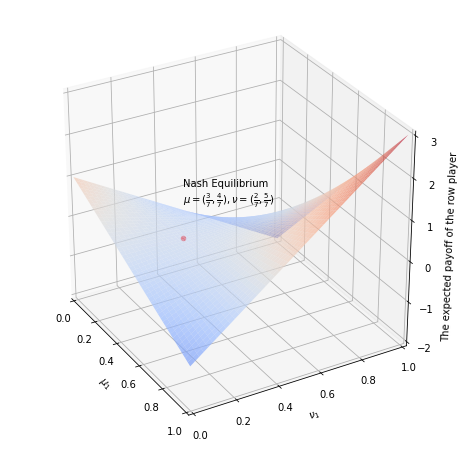

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm
import numpy as np


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

R = np.array([[3, -1],
              [-2, 1]])      # Presidency Strategies Game

u_1 = np.linspace(0, 1)
u = np.stack([u_1, 1 - u_1])
v_1 = np.linspace(0, 1)
v = np.stack([v_1, 1 - v_1])
payoff = u.T.dot(R).dot(v)
u_1, v_1 = np.meshgrid(u_1, v_1, indexing='ij')

surf = ax.plot_surface(u_1, v_1, payoff, cmap=cm.coolwarm, alpha=0.7)
ax.scatter(*zip((3 / 7, 2 / 7, 1 / 7)), color='red')
ax.text(3 / 7, 2 / 7, 1, "Nash Equilibrium\n$\\mu = (\\frac{3}{7}, \\frac{4}{7}), \\nu = (\\frac{2}{7}, \\frac{5}{7})$")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(-2, 3)
ax.set_xlabel('$\mu_1$')
ax.set_ylabel('$\\nu_1$')
ax.set_zlabel('The expected payoff of the row player')
ax.view_init(30, -30)
plt.show()

In [ ]:
def animate(frame):
  ax.view_init(30, frame/4)
  plt.pause(.001)
  return fig

anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
HTML(anim.to_html5_video())

In [ ]:
num_frames = 50
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(u_1, v_1, payoff, cmap=cm.coolwarm, alpha=0.5)
ax.scatter(*zip((3 / 7, 2 / 7, 1 / 7)), color='red')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(-2, 3)
ax.set_xlabel('$\mu_1$')
ax.set_ylabel('$\\nu_1$')
ax.set_zlabel('payoff')
ax.view_init(30, -30)
plt.close()

def animate(frame):
  u_1 = frame / (num_frames - 1)
  u = np.array([u_1, 1 - u_1])
  payoff_0 = u.dot(R).dot(np.array([0, 1]))
  payoff_1 = u.dot(R).dot(np.array([1, 0]))

  ax.lines = []
  ax.texts = []
  ax.plot(*zip((u_1, 0, -2), (u_1, 0, 3), (u_1, 1, 3), (u_1, 1, -2), (u_1, 0, -2)), label='', color='black')
  ax.plot(*zip((u_1, 0, payoff_0), (u_1, 1, payoff_1)), label='Expected payoff of the column player\nwhen the row player\'s strategy is $\mu = (%.2f, %.2f)$' % (u_1, 1 - u_1),
          color='red' if np.allclose(payoff_0, payoff_1) else 'blue')
  ax.text(u_1, 0, payoff_0, "%.2f" % payoff_0)
  ax.text(u_1, 1, payoff_1, "%.2f" % payoff_1)
  ax.legend()
  return fig

anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=500)
HTML(anim.to_html5_video())

In [ ]:
num_frames = 50
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(u_1, v_1, payoff, cmap=cm.coolwarm, alpha=0.5)
ax.scatter(*zip((3 / 7, 2 / 7, 1 / 7)), color='red')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(-2, 3)
ax.set_xlabel('$\mu_1$')
ax.set_ylabel('$\\nu_1$')
ax.set_zlabel('payoff')
ax.view_init(30, -30)
plt.close()

def animate(frame):
  v_1 = frame / (num_frames - 1)
  v = np.array([v_1, 1 - v_1])
  payoff_0 = np.array([0, 1]).dot(R).dot(v)
  payoff_1 = np.array([1, 0]).dot(R).dot(v)

  ax.lines = []
  ax.texts = []
  ax.plot(*zip((0, v_1, -2), (0, v_1, 3), (1, v_1, 3), (1, v_1, -2), (0, v_1, -2)), label='', color='black')
  ax.plot(*zip((0, v_1, payoff_0), (1, v_1, payoff_1)), label='Expected payoff of the row player\nwhen the column player\'s strategy is $\\nu = (%.2f, %.2f)$' % (v_1, 1 - v_1),
          color='red' if np.allclose(payoff_0, payoff_1) else 'blue')
  ax.text(0, v_1, payoff_0, "%.2f" % payoff_0)
  ax.text(1, v_1, payoff_1, "%.2f" % payoff_1)
  ax.legend()
  return fig

anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=500)
HTML(anim.to_html5_video())

## Part 2: Support Enumeration and Vertex Enumeration

### 2.1 Bimatrix Game and the Best Response Condition

$(A, B)$ is a bimatrix game in which $A$ and $B$ are $M \times N$ matrices of payoffs to the row player 1 and column player 2. An example is provided below:

$$A = \begin{pmatrix}3 & 3 \\ 2 & 5 \\ 0 & 6\end{pmatrix}, B = \begin{pmatrix}3 & 2 \\ 2 & 6 \\ 3 & 1\end{pmatrix}$$

Let us revisit the problem type in [Notebook 2](https://colab.research.google.com/drive/1eYRRgVY0ZJC7bEzxSKFN2_skdUWvXjaw?usp=sharing), to find the Nash equilibrium of this example by two stages. Especially to be familiar with the matrix-form notation.

1. Only **ONE** of the strategies is selected for the column player (i.e., the pure strategy)
    - The column player plays column 1, $y = (1, 0)^\top$:
        - The expected payoffs of the row player for playing each pure strategy are $Ay = (3, 2, 0)^\top$ (column 1 of $A$). 3 for playing row 1, 2 for playing row 2, and 0 for playing row 3.
        - The expected payoff of the row player for playing $x = (x_1, x_2, x_3)$ is $x^\top Ay = 3x_1 + 2x_2 + 0x_3. \sum x_i = 1, x_i \geq 0$.
        - The best response $x$ to the column player's strategy $y$ should be the one that maximize $x^\top Ay$. To achieve this, we show the upper bound of $x^\top Ay$, and how to choose $x$ so that $x^\top Ay$ reaches the upper bound.
            - **(Finding the upper bound of $x^\top Ay$)** Note that the maximal expected payoff is $\max(3, 2, 0) = 3$, so we can rewrite the payoffs as the maximal one minus the gap between the current one and the maximal one. Also note that $\sum x_i = 1$ and $x_i \geq 0$, then we have
            
            \begin{align}
            x^\top Ay &= (3 - 0)x_1 + (3 - 1)x_2 + (3 - 3)x_3 \\
            &= 3(\underbrace{x_1 + x_2 + x_3}_{=1}) - 0x_1 -  1x_2 - 3x_3 \\
            &= 3 - \underbrace{0x_1}_{\geq 0} -  \underbrace{1x_2}_{\geq 0} - \underbrace{3x_3}_{\geq 0} \leq 3
            \end{align}

            - **(How to reach the upper bound of $x^\top Ay$)** Therefore, to maximize the expected payoff $x^\top Ay$, we should make sure that the strategies with positive probabilities has a coefficient of zero.
            - That is, the best response of the row player is to play $x = (1, 0, 0)$, so that $x^\top Ay$ reaches the upper bound 3.
        - Then when the row player plays row 1, $x = (1, 0, 0)$, the expected payoff of the column player is $x^\top B = (3, 2)$ (row 1 of $B$), the best response of the column player is to play column 1 (3 > 2).
        - So $((1, 0, 0), (1, 0))$ is a Nash equilibrium.
        - **Why it is not reasonable for the row player to play a mixed strategy** with more than one strategy probabilities larger than 0? What if the column 1 of $A$ equals to $(2, 2, 0)^\top$ or $(2, 2, 2)^\top$?
    - The column player plays column 2, $y = (0, 1)^\top$:
        - ...

2. **TWO** of the strategies are selected for the column player, $y = (y_1, y_2), y_1, y_2 > 0, y_1 + y_2 = 1$
    - The expected payoffs of the row player for playing each pure strategy (row 1, 2, 3) are $Ay = (3y_1 + 3y_2, 2y_1 + 5y_2, 0y_1 + 6y_2)^\top$
        - Expected payoff for playing row 1: $(Ay)_1 = 3y_1 + 3y_2$
        - Expected payoff for playing row 2: $(Ay)_2 = 2y_1 + 5y_2$
        - Expected payoff for playing row 3: $(Ay)_3 = 0y_1 + 6y_2$
    - The expected payoff of the row player for playing $x = (x_1, x_2, x_3)$ is $x^\top Ay = (Ay)_1 x_1 + (Ay)_2 x_2 + (Ay)_3 x_3. \sum x_i = 1, x_i \geq 0$
    - The best response $x$ to the column player's strategy $y$ should be the one that maximize $x^\top Ay$. To achieve this, we show the upper bound of $x^\top Ay$, and what condition should $x$ and $y$ satisfy so that $x^\top Ay$ reaches the upper bound (thus the expected payoff of playing $x$ given $y$ is maximized, and $x$ is the best response to $y$).
        - **(Finding the upper bound of $x^\top Ay$)** Let the maximal payoff $u = \max[(Ay)_1, (Ay)_2, (Ay)_3]$, and the gap between the maximal one and the $i$th one be $u - (Ay)_i \geq 0$, so
        
        \begin{align}
        x^\top Ay &= u(\underbrace{x_1 + x_2 + x_3}_{=1}) - (u - (Ay)_1)x_1 - (u - (Ay)_2)x_2 - (u - (Ay)_3)x_3 \\
        &= u - (\underbrace{u - (Ay)_1}_{\geq 0})x_1 - (\underbrace{u - (Ay)_2}_{\geq 0})x_2 - (\underbrace{u - (Ay)_3}_{\geq 0})x_3 \leq u
        \end{align}
        - **(How to reach the upper bound of $x^\top Ay$)** Therefore, to maximize the expected payoff $x^\top Ay$, we should make sure that the strategies with positive probabilities has a coefficient of zero. (in such a case $x^\top Ay$ reaches the upper bound $u$.)
        - That is, to maximize $x^\top Ay$, the **Best Response Condition** is: for each $x_i > 0$, $u - (Ay)_i = 0$, i.e., $(Ay)_i = u$.
    - We name the set of indices $i$ in which $x_i > 0$ **the support set $I$ of strategy $x$**. The best response condition can be restated as: for each index $i$ in $x$'s support set, $(Ay)_i = u$.
    - Assume we already know the support set $I$ of strategy $x$, then we can determine $y_1, y_2$ (and the corresponding $u$) so that any $x$ with support set $I$ is the best response to $y = (y_1, y_2)$, by the following linear equations:

    \begin{align}
        (Ay)_i &= u, i \in I \\
        y_1 + y_2 &= 1
    \end{align}

    So we have 3 variables and $|I| + 1$ equations. $|I| = 2$ leads to a unique solution. (Named the typical "nondegenerate" case)
    - However, this is only a necessary condition for strategy $x$ with supporting set $I$ to be a best response. We also need to check the following conditions:
        - Are $y_1, y_2 \geq 0$?
        - Is $u$ equals to $\max[(Ay)_1, (Ay)_2, (Ay)_3]$?
    - The support set $I$ of strategy $x$ can be determined by enumerating all possibilities
        - $I = \{1, 2\}$ (The row player only plays row 1 and 2 with positive probabilities):
            - According to the best response condition, we have the following linear equations so that strategy $x$ with support set $I$ is the best response to $y = (y_1, y_2)$:

            \begin{align}
                (Ay)_1 &= u \quad (3y_1 + 3y_2 - 1u = 0)\\
                (Ay)_2 &= u \quad (2y_1 + 5y_2 - 1u = 0)\\
                y_1 + y_2 &= 1 \quad (1y_1 + 1y_2 + 0u = 1)
            \end{align}

            So $y_1 = 2/3, y_2 = 1/3, u = 3$
            - Check another two conditions:
                - $y_1, y_2 \geq 0$
                - $((Ay)_1, (Ay)_2, (Ay)_3) = (3, 3, 2)$, $u = \max[(Ay)_1, (Ay)_2, (Ay)_3]$
            - So the result is valid. Any strategy $x$ of the row player with support set $I = \{1, 2\}$ is the best response to strategt $y = (2/3, 1/3)$ of the row player.
            - Similarly, the support set of the column player is $J = \{1, 2\}$, so according to the best response condition, we also have the following linear equations so that strategy $y$ of the column player with support set $J$ is the best response to strategy $x = (x_1, x_2, 0)$ of the row player:

            \begin{align}
                (x^\top B)_1 &= v \quad (3x_1 + 2x_2 - 1v = 0)\\
                (x^\top B)_2 &= v \quad (2x_1 + 6x_2 - 1v = 0)\\
                x_1 + x_2 &= 1 \quad (1x_1 + 1x_2 + 0u = 1)
            \end{align}

            So $x_1 = 4/5, x_2 = 1/5, u = 14/3$
            - Check another two conditions:
                - $x_1, x_2 \geq 0$
                - $((x^\top B)_1, (x^\top B)_2) = (14/3, 14/3)$, $v = \max[(x^\top B)_1, (x^\top B)_2]$
            - So the result is valid. Any strategy $y$ of the column player with support set $J = \{1, 2\}$ is the best response to strategy $x = (4/5, 1/5, 0)$ of the row player.

            - Therefore, $((4/5, 1/5, 0), (2/3, 1/3))$ is a Nash equilibrium.
        - $I = \{1, 3\}$ ...
        - $I = \{2, 3\}$ ...

Here is a more generic description of the best response condition:

> **Best Response Condition**: Let $x$ and $y$ be mixed strategies of player 1 and 2 respectively, then $x$ is a best response to $y$ if and only if
> $$\forall i = 1, \cdots, M, x_i \gt 0 \Rightarrow (Ay)_i = u = \max\{(Ay)_k | k = 1, \cdots, M\}$$
> (Here $(Ay)_i$ means the $i$-th component of $M$-dimensional vector $Ay$)

This seems a little complicated, but it is the core to understand all the following algorithms. We unfold the condition as three parts:

1. (Payoff maximization) Given $y$, $(Ay)_i$ is the expected payoff of player 1 when playing row $i$. If $x$ is a pure strategy, then player should play row $i$ so that $(Ay)_i$ is maximized. That is, $(Ay)_i = \max\{(Ay)_k | k = 1, \cdots, M\}$. E.g., when $y = (1, 0)^\top$, $Ay = (3, 2, 0)^\top$. In this case player 1 should always play row 1 to get maximal payoff (3), and $x = (1, 0, 0)$ is the best response.
2. (Indifference) However, what if there are multiple $(Ay)_i$ that reach the maximum? E.g., when $y = (2/3, 1/3)^\top$, $Ay = (3, 3, 2)$. In this case playing row 1 or 2 are indifferent. All $x$ satisfying $x_3 = 0, x_1 + x_2 = 1$ are the best responses.
3. (Support set) For a mixed strategy $x$, we called the index set $\{i | x_i > 0\}$ as the *support set*. E.g., when $x = (0.8, 0.2, 0)$, the support set of $x$ is $\{1, 2\}$.

Therefore, to check whether a mixed strategy $x$ is the best response of $y$, we have the following steps:

1. Find the support set of $x$, denoted as $I$
2. Check if all $(Ay)_i, i \in I$ are equal ($= u$)
3. Check whether $u$ is the largest in $(Ay)_i, i \in \{1, \cdots, M\}$

Support enumeration is a direct derivation of the best response condition. We just enumerate all the possibility of support (the possibility of non-support action is set to 0), solve $x$ and $y$ via the indifference condition, and check whether they are the best response of each other following the best response condition. More details can be found in Section 3.2 of Ref [1].

- For $k = 1, \cdots, \min(M, N)$
    - For $I \in \text{k-sized subsets of } \\{1, \cdots, M\\}$
        - For $J \in \text{k-sized subsets of } \\{1, \cdots, N\\}$
            - Set $x_i = 0, \forall i \notin I$, $y_j = 0, \forall j \notin J$
            - Solve the following linear equations \begin{align}
                \sum_{i \in I} x_i B_{ij} &= v, ~\forall j \in J \ \ (1)\\
                \sum_{i \in I} x_i &= 1    \ \ (2)
            \end{align}
            and
            \begin{aligned}
                \sum_{j \in J} A_{ij} y_j &= u, ~\forall i \in I \\
                \sum_{j \in J} y_j &= 1 \\
            \end{aligned}
            - If $x_i \geq 0, \forall i \in I$ and $y_j \geq 0, \forall j \in J$ (so $x$ and $y$ are valid strategies)
                - If $u = \max\\{(Ay)_i | i = 1, \cdots, M\\}$ and $v = \max\\{(x^\top B)_i | i = 1, \cdots, N\\}$
                    - Output $x, y$ as an mixed equilibrium.

#### Q3: Compute the Nash equilibrium by support enumeration

Your first task is to implement a function `subsets(k, N)` that enumerate all combination of k-sized subsets in $\{1, \cdots, N\}$. A sample input/output is as follows:

```
>>> print(subsets(3, 5))
>>> [[0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 2, 3], [0, 2, 4], [0, 3, 4], [1, 2, 3], [1, 2, 4], [1, 3, 4], [2, 3, 4]]
```

Tips:

- Considering using [Backtracing](https://en.wikipedia.org/wiki/Backtracking).
- The `itertools` package in Python can also do the job.



In [ ]:
def subsets(k, N, current_subset=[], result=[]):
    if len(current_subset) == k:
        result.append(current_subset.copy())
    else:
        start_index = 0 if len(current_subset) == 0 else current_subset[-1] + 1
        for i in range(start_index, N):
            current_subset.append(i)
            subsets(k, N, current_subset)
            current_subset.pop()
    if len(current_subset) == 0:
        result_copied = result.copy()
        result.clear()
        return result_copied

print(subsets(3, 5))

import itertools
print(list(itertools.combinations(range(5), 3)))

[[0, 1, 2], [0, 1, 3], [0, 1, 4], [0, 2, 3], [0, 2, 4], [0, 3, 4], [1, 2, 3], [1, 2, 4], [1, 3, 4], [2, 3, 4]]
[(0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 3), (0, 2, 4), (0, 3, 4), (1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4)]


Then, please implement the support enumeration algorithm by filling the following blanks

Tips:
- You can use `x = np.linalg.solve(A, b)` to solve the linear equation $Ax = b$, which, for instance, should include Eqs (1) and (2) for $x$ case. [[NumPy Docs]](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html)

In [ ]:
import numpy as np

A = np.array([[3, 3], [2, 5], [0, 6]])
B = np.array([[3, 2], [2, 6], [3, 1]])

M, N = A.shape
for k in range(1, min(M, N)+1 ):
    print("support size:", k)
    for I in subsets(k, M):
        for J in subsets(k, N):
            print("support for player 1: %s; support for player 2: %s" % (I, J))
            A_subset = A[np.ix_(I, J)]
            B_subset = B[np.ix_(I, J)]
            ### TODO: solve the linear equations ###
            b = np.concatenate([_, _])
            constraint = np.block([[_, _],
                                   [_, _]])
            x_support = np.linalg.solve(constraint, b)[:-1]
            constraint = np.block([[_, _],
                                   [_, _]])
            y_support = np.linalg.solve(constraint, b)[:-1]
            ### END TODO ###
            x = np.zeros(M)
            x[I] = x_support
            y = np.zeros(N)
            y[J] = y_support
            ### TODO: verify that x and y are valid strategies ###
            if _ and _:
            ### END TODO ###
                x_expected_payoff = A.dot(y)    # Ay
                y_expected_payoff = B.T.dot(x)  # x^\top B
                ### TODO: verify that u = max{(Ay)_i} and v = max{(x^\top B)_i} ###
                if np.isclose(x_expected_payoff[I[0]], _) and np.isclose(y_expected_payoff[J[0]], _):
                    print(x, y)
                ### END TODO ###

support size: 1
support for player 1: [0]; support for player 2: [0]
[1. 0. 0.] [1. 0.]
support for player 1: [0]; support for player 2: [1]
support for player 1: [1]; support for player 2: [0]
support for player 1: [1]; support for player 2: [1]
support for player 1: [2]; support for player 2: [0]
support for player 1: [2]; support for player 2: [1]
support size: 2
support for player 1: [0, 1]; support for player 2: [0, 1]
[0.8 0.2 0. ] [0.66666667 0.33333333]
support for player 1: [0, 2]; support for player 2: [0, 1]
support for player 1: [1, 2]; support for player 2: [0, 1]
[0.         0.33333333 0.66666667] [0.33333333 0.66666667]


### 2.2 Best-response Polyhedron and Labeling

#### 2.2.1 Best-response Polyhedron

For a given strategy $y$ of player 2, the expected payoffs of player 1 when playing row $1, \cdots, M$ is $Ay$. For our example, that is

$$Ay = (3y_1 + 3y_2, 2y_1 + 5y_2, 0y_1 + 6y_2)^\top$$

That is,

- when player 1 plays row 1, the expected payoff is $3y_1 + 3y_2$
- when player 1 plays row 2, the expected payoff is $2y_1 + 5y_2$
- when player 1 plays row 3, the expected payoff is $0y_1 + 6y_2$

To analyse the relation between $y = (y_1, y_2)$ and the maximum element of $Ay$ (corresponding to the best response of player 1), we add a constraint $Ay \leq \textbf{1}u$. For our example, that is

\begin{align}
3y_1 + 3y_2 \leq u \quad \text{(row 1)}\\
2y_1 + 5y_2 \leq u \quad \text{(row 2)}\\
0y_1 + 6y_2 \leq u \quad \text{(row 3)}
\end{align}

with the constraint

\begin{align}
y_1 &\geq 0 \quad &\text{(col 1)} \\
y_2 &\geq 0 \quad (1 - y_1 \geq 0) \quad &\text{(col 2)}
\end{align}

So the minimum value of $u$ equals to the maximum value of $(Ay)_i$.

In the following figure, we plot the feasible region of $u$ defind by the above linear inequality constraints with respect to $y_1$. Actually, the feasible region is a polyhedron, denoted as $\bar{Q}$. In this way we can easily find the minimum value of $u$ w.r.t. $y_1$.

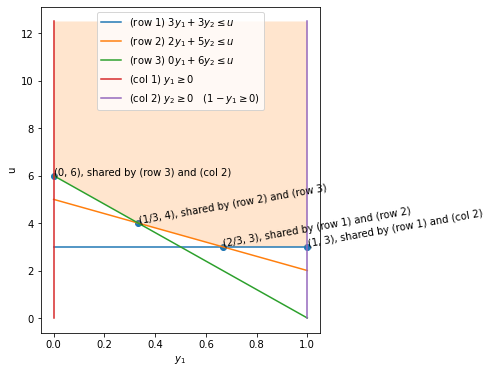

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (5, 6)

y_1 = np.linspace(0, 1)
plt.plot(y_1, 3 * y_1 + 3 * (1 - y_1), label='(row 1) $3y_1 + 3y_2 \leq u$')
plt.plot(y_1, 2 * y_1 + 5 * (1 - y_1), label='(row 2) $2y_1 + 5y_2 \leq u$')
plt.plot(y_1, 0 * y_1 + 6 * (1 - y_1), label='(row 3) $0y_1 + 6y_2 \leq u$')
u = np.linspace(0, 12.5)
plt.plot(u * 0, u, label='(col 1) $y_1 \geq 0$')
plt.plot(u * 0 + 1, u, label='(col 2) $y_2 \geq 0 \quad (1 - y_1 \geq 0)$')
plt.scatter([0, 1/3, 2/3, 1], [6, 4, 3, 3])
plt.fill([0, 0, 1/3, 2/3, 1, 1], [12.5, 6, 4, 3, 3, 12.5], alpha=0.2)
plt.annotate("(0, 6), shared by (row 3) and (col 2)", (0, 6))
plt.annotate("(1/3, 4), shared by (row 2) and (row 3)", (1/3, 4), rotation=10)
plt.annotate("(2/3, 3), shared by (row 1) and (row 2)", (2/3, 3), rotation=10)
plt.annotate("(1, 3), shared by (row 1) and (col 2)", (1, 3), rotation=10)
plt.xlabel('$y_1$')
plt.ylabel('u')
plt.legend()
plt.show()

In this case, for vertex $(\frac{1}{3}, 4)$ in polyhedron $\bar{Q}$, the mininum value of $u$ equals to 4 when $(y_1, y_2) = (\frac{1}{3}, \frac{2}{3})$. That is,
- (row 1) $3y_1 + 3y_2 = \frac{3}{3} + \frac{6}{3} = 3 < 4$
- (row 2) $\color{red}{2y_1 + 5y_2 = \frac{2}{3} + \frac{10}{3} = 4}$
- (row 3) $\color{red}{0y_1 + 6y_2 = \frac{0}{3} + \frac{12}{3} = 4}$
- (col 1) $y_1 = \frac{1}{3} > 0$
- (col 2) $y_2 = \frac{2}{3} > 0$

Here we marked the inequality constraints ($\leq$ or $\geq$) in red if the equality holds. In geometry, this means the hyperplanes pass through the point. Since this polyhedron is in a 2-dimensional space, a vertex is the crossing of 2 hyperplanes, so we can mark 2 constraints in red for each vertex (for other non-vertex point on the surface of the polyhedron, we can mark less than 2 constraints). Note that we mark a constraint as red only when

- (row 1 ~ row 3) Its corresponding row is a best response to the column player, i.e., player 2. This is because the expected payoff of playing this row is exactly equal to the minimum value of $u$.
- (col 1 ~ col 2) Its corresponding column has probability zero, i.e., the column player will never play this column.

Here, for vertex $(\frac{1}{3}, 4)$ on polyhedron $\bar{Q}$, since both the expected payoff of playing row 2 and row 3 are 4, which is larger than playing row 1 (expected payoff 3), it will be no difference whether player 1 plays row 2 or row 3. Recall the best response condition, any strategy $(x_1, x_2, x_3)$ with a support set of $\{2, 3\}$ will be the best response to player 2's strategy $(y_1, y_2) = (\frac{1}{3}, \frac{2}{3})$. E.g., $(x_1, x_2, x_3) = (0, \frac{1}{3}, \frac{2}{3})$.

Similarly, we analyze the relation between $x = (x_1, x_2, x_3)$ and the maximum element of $B^\top x$ (corresponding to the best response of player 2), we add a constraint $B^\top x \leq \textbf{1}v$. For our example, that is

- $x_1 \geq 0$
- $x_2 \geq 0$
- $x_3 \geq 0 \quad (1 - x_1 - x_2 \geq 0)$

- $3x_1 + 2x_2 + 3x_3 \leq v$
- $2x_1 + 6x_2 + 1x_3 \leq v$

Since $x_3 = 1 - x_1 - x_2$, we can also plot the feasible region of $v$ w.r.t. $x_1$ and $x_2$,

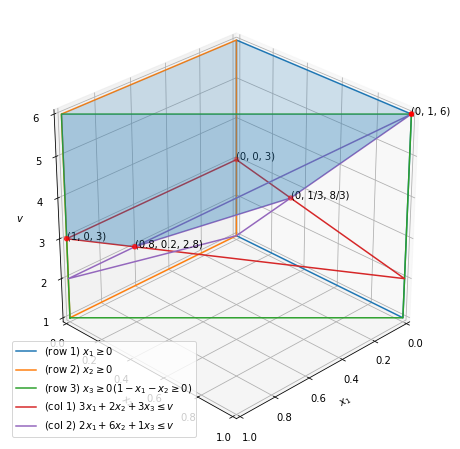

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(*zip((0, 0, 1), (0, 1, 1), (0, 1, 6), (0, 0, 6), (0, 0, 1)), label='(row 1) $x_1 \geq 0$')
ax.plot(*zip((0, 0, 1), (1, 0, 1), (1, 0, 6), (0, 0, 6), (0, 0, 1)), label='(row 2) $x_2 \geq 0$')
ax.plot(*zip((1, 0, 1), (1, 0, 6), (0, 1, 6), (0, 1, 1), (1, 0, 1)), label='(row 3) $x_3 \geq 0 (1 - x_1 - x_2 \geq 0)$')
ax.plot([1, 0, 0, 1], [0, 1, 0, 0], [3, 2, 3, 3], label='(col 1) $3x_1 + 2x_2 + 3x_3 \leq v$')
ax.plot([0, 0, 0.8, 1, 0, 0, 0.8], [1/3, 1, 0.2, 0, 0, 1/3, 0.2], [8/3, 6, 2.8, 2, 1, 8/3, 2.8], label='(col 2) $2x_1 + 6x_2 + 1x_3 \leq v$')
ax.add_collection3d(Poly3DCollection([[(0, 1, 6), (0, 0, 6), (0, 0, 3), (0, 1/3, 8/3)]], alpha=0.2))
ax.add_collection3d(Poly3DCollection([[(1, 0, 6), (0, 0, 6), (0, 0, 3), (1, 0, 3)]], alpha=0.2))
ax.add_collection3d(Poly3DCollection([[(1, 0, 6), (1, 0, 3), (0.8, 0.2, 2.8), (0, 1, 6)]], alpha=0.2))
ax.add_collection3d(Poly3DCollection([[(0.8, 0.2, 2.8), (0, 1, 6), (0, 1/3, 8/3)]], alpha=0.2))
ax.add_collection3d(Poly3DCollection([[(1, 0, 3), (0.8, 0.2, 2.8), (0, 1/3, 8/3), (0, 0, 3)]], alpha=0.2))
ax.scatter([0, 0.8, 0, 1, 0], [1/3, 0.2, 1, 0, 0], [8/3, 2.8, 6, 3, 3], color='red')
ax.text(1, 0, 3, "(1, 0, 3)")
ax.text(0, 1/3, 8/3, "(0, 1/3, 8/3)")
ax.text(0.8, 0.2, 2.8, "(0.8, 0.2, 2.8)")
ax.text(0, 1, 6, "(0, 1, 6)")
ax.text(0, 0, 3, "(0, 0, 3)")
ax.view_init(elev=30, azim=45)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(1, 6)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$v$')
ax.legend()
plt.show()

def animate(frame):
  ax.view_init(30, frame/4)
  plt.pause(.001)
  return fig

anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
HTML(anim.to_html5_video())

In this case, the feasible region of $v$ (a polyhedron denoted as $\bar{P}$) is the region above the five vertices shown in the figure.

for vertex $(0, \frac{1}{3}, \frac{8}{3})$ in polyhedron $\bar{P}$, the mininum value of $v$ equals to $\frac{8}{3}$ when $(x_1, x_2, x_3) = (0, \frac{1}{3}, 1 - 0 - \frac{1}{3} = \frac{2}{3})$. That is,
- (row 1) $\color{red}{x_1 = 0}$
- (row 2) $x_2 = \frac{1}{3} > 0$
- (row 3) $x_3 = \frac{2}{3} > 0$
- (col 1) $\color{red}{3x_1 + 2x_2 + 3x_3 = \frac{2}{3} + \frac{6}{3} = \frac{8}{3}}$
- (col 2) $\color{red}{2x_1 + 6x_2 + 1x_3 = \frac{6}{3} + \frac{2}{3} = \frac{8}{3}}$

Since this polyhedron is in a 3-dimensional space, a vertex is the crossing of 3 hyperplanes, so we can mark 3 constraints in red for each vertex (for other non-vertex point on the surface of the polyhedron, we can mark less than 3 constraints). Similar to polyhedron $\bar{Q}$, here we mark a constraint as red only when

- (col 1 ~ col 2) Its corresponding column is a best response to the row player, i.e., player 1.
- (row 1 ~ row 3) Its corresponding row has probability zero, i.e., the row player will never play this row.

Since both the expected payoff of playing col 1 and col 2 are $\frac{8}{3}$, it will be no difference whether player 2 plays col 1 or col 2. Recall the best response condition, any strategy $(y_1, y_2)$ with a support set of $\{1, 2\}$ will be the best response to player 1's strategy $(x_1, x_2, x_3) = (0, \frac{1}{3}, \frac{2}{3})$. E.g., $(y_1, y_2) = (\frac{1}{3}, \frac{2}{3})$.

#### 2.2.2 Labeling

From the above analysis of two polyhedrons $\bar{Q}$ and $\bar{P}$, we know that
- (Polyhedron $\bar{Q}$) Player 1's strategy $(x_1, x_2, x_3) = (0, \frac{1}{3}, \frac{2}{3})$ is the best response for player 2's strategy $(y_1, y_2) = (\frac{1}{3}, \frac{2}{3})$.
- (Polyhedron $\bar{P}$) Player 2's strategy $(y_1, y_2) = (\frac{1}{3}, \frac{2}{3})$ is the best response for player 1's strategy $(x_1, x_2, x_3) = (0, \frac{1}{3}, \frac{2}{3})$.

Therefore, the pair of the two strategies is a Nash equilibrium.

Interestingly, if we list the constraints of the two polyhedrons $\bar{Q}$ and $\bar{P}$ in parallel, with the red mark for vertex $(\frac{1}{3}, 4)$ on $\bar{Q}$ (best response to player 2's strategy $(\frac{1}{3}, \frac{2}{3})$) and vertex $(0, \frac{1}{3}, \frac{8}{3})$ on $\bar{P}$ (best response to player 1's strategy $(0, \frac{1}{3}, \frac{2}{3})$), we will find that the red marks are perfectly complementary with each other. In this way, **each pure strategy is a best response or has probability zero**, so the two strategies are mutual best responses, corresponding to a Nash equilibrium.

| "Label" | vertex $(\frac{1}{3}, 4)$ on $\bar{Q}$ <img width=150px/> | relation | vertex $(0, \frac{1}{3}, \frac{8}{3})$ on $\bar{P}$ <img width=180px/> |
| - | ---- | - | ---- |
| row 1 | $3y_1 + 3y_2 = \frac{3}{3} + \frac{6}{3} = 3 < 4$ | row 1 is NOT the best response to player 2, should NOT play → | $\color{red}{x_1 = 0}$ |
| row 2 | $\color{red}{2y_1 + 5y_2 = \frac{2}{3} + \frac{10}{3} = 4}$ | row 2 is a best response to player 2's strategy → | $x_2 = \frac{1}{3} > 0$ |
| row 3 | $\color{red}{0y_1 + 6y_2 = \frac{0}{3} + \frac{12}{3} = 4}$ | row 3 is a best response to player 2's strategy → | $x_2 = \frac{2}{3} > 0$ |
| col 1 | $y_1 = \frac{1}{3} > 0$ | ← col 1 is a best response to player 1's strategy | $\color{red}{3x_1 + 2x_2 + 3x_3 = \frac{2}{3} + \frac{6}{3} = \frac{8}{3}}$ |
| col 2 | $y_2 = \frac{2}{3} > 0$ | ← col 2 is a best response to player 1's strategy | $\color{red}{2x_1 + 6x_2 + 1x_3 = \frac{6}{3} + \frac{2}{3} = \frac{8}{3}}$ |

If we assign a set of "labels" (named "labeling") to each vertex, e.g., assign vertex $(\frac{1}{3}, 4)$ on $\bar{Q}$ a label set {row 2, row 3} and vertex $(0, \frac{1}{3}, \frac{8}{3})$ on $\bar{P}$ a label set {row 1, col 1, col 2}, the problem of finding a Nash equilibrium becomes finding a pair of vertices whose label sets contain all labels (named "completely labeled"). E.g., {row 2, row 3}∪{row 1, col 1, col 2} = {row 1, row 2, row 3, col 1, col 2} is the set of all available labels, so the vertex pair $(\frac{1}{3}, 4)$ and $(0, \frac{1}{3}, \frac{8}{3})$ corresponds to a Nash equilibrium.

In this example, $\bar{Q}$ contains 4 vertices $(0, 6), (\frac{1}{3}, 4), (\frac{2}{3}, 3), (1, 3)$, $\bar{P}$ contains 5 vertices $(0, 0, 3), (1, 0, 3), (0.8, 0.2, 2.8), (0, \frac{1}{3}, \frac{8}{3}), (0, 1, 6)$. So we have a total of $4 \times 5 = 20$ combinations of vertice pairs. Enumerating the 20 vertice pairs and check whether their label sets cover all labels (completely labeled), then we can have all Nash equilibrium of this example. Besides $(\frac{1}{3}, 4)$ and $(0, \frac{1}{3}, \frac{8}{3})$, the following vertex pairs also correspond to Nash equilibrium

- $(\frac{2}{3}, 3)$ ({row 1, row 2}) and $(0.8, 0.2, 2.8)$ ({row 3, col 1, col 2})
- $(1, 3)$ ({row 1, col 2}) and $(1, 0, 3)$ ({row 2, row 3, col 1})

Finding Nash equilibrium in this way is called "vertex enumeration".

#### 2.2.3 Simplified Best-response Polyhedron

Currently we are very close to the final formulation of vertex enumeration algorithm. However, it can be a little complicated to compute all the vertices of the polyhedron
$$\bar{Q} = \{(y_1, \cdots, y_{N - 1}, u) \in \mathbb{R}^N | Ay \leq \textbf{1}u, y \geq \textbf{0}, \sum_{i=1}^N y_i = 1)\}$$
directly, since it contains an additional variable $u$ and a linear constraint $\sum y_i = 1$. For the sake of simplicity in implementation, we "normalize" the constraint $Ay \leq \textbf{1}u$ of $\bar{Q}$ by dividing each inequality by $u$, i.e., $A(y / u) \leq 1$. Let $\hat{y} = y / u$ (that is, $\hat{y}_i = y_i / u$), we have a new polyhedron
$$Q = \{\hat{y} \in \mathbb{R}^N | A\hat{y} \leq \textbf{1}, \hat{y} \geq 0, \sum_{i=1}^N \hat{y}_i = 1 / u\}$$

After the normalization, $u$ becomes an isolated free variable whose value can be arbitrary, so the constraint $\sum_{i=1}^N \hat{y}_i = 1 / u$ is to say that $\sum_{i=1}^N \hat{y}_i$ can be anything (excluding zero), thus can be dropped.

Therefore, the actual "best-response polyhedrons" we use are as follows:

$$Q = \{y \in \mathbb{R}^N | Ay \leq \textbf{1}, y \geq \textbf{0}\}$$

Matrix form: $Qx + b \leq 0$ in which $Q = \begin{pmatrix}A \\ -I \end{pmatrix}$ is a $(M + N) \times N$ matrix and $b = \begin{pmatrix}-\textbf{1}^M \\ 0 \end{pmatrix}$ is a vector with length $M + N$.

$$P = \{x \in \mathbb{R}^M | x \geq \textbf{0}, B^\top x \leq \textbf{}1\}$$

Matrix form: $Px + b \leq 0$ in which $P = \begin{pmatrix}-I \\ B^\top \end{pmatrix}$ is a $(M + N) \times M$ matrix and $b = \begin{pmatrix}0 \\ -\textbf{1}^N \end{pmatrix}$ is a vector with length $M + N$. ($\mathbb{1}^N$ is an all-one vector of length $N$)

Also, for the sake of simplicity in implementation, the label "row 1" to "row M" are denoted as integer $1, \cdots, M$, label "col 1" to "col N" are denoted as integer $M + 1, \cdots, M + N$.

#### 2.2.4 Vertex Enumeration Algorithm

First, compute all vertices of the above polyhedrons with their labels. For a polyhedron $Ax \leq b$ with $k$ variables, this can be brutely achieved by enumerating all possible $k$-sized combination of halfspaces, compute their intersection point $x$ by solving linear equations, and check whether the point is a valid vertex by checking whether $Ax \leq b$ holds for all constraints. The procedure is as follows

- vertices = [], labels = []
- For $label \in \text{k-sized subset of }\{1, \cdots, M + N\}$
    - $A' = A[label]$ (that is, a $k \times k$ matrix containing the rows of $A$ with row indices in $label$)
    - $b' = b[label]$
    - Solve $x$ for the linear equations $A'x = b'$ (that is, the intersection of the above $k$ halfspaces.
    - If $\forall i \in 1,\cdots, M + N, A_i x + b_i \leq 0$
        - add $x$ to vertices, $label$ to labels
- return vertices and labels

After we have the vertices with their labels for best-response polyhedron $P$ and $Q$, we can enumerate the vertice-label pair of both $P$ and $Q$ to see if there is a combination of vertex pair $(u, v), u \in P \text{ and } v \in Q$ so that the union of the labels of $u$ and $v$ is the full label set $\{1,\cdots, M + N\}$. That is

- Remove all-zero vertex $x$ from the vertex set of both $P$ and $Q$
- For $u\in \text{vertices of } P$
    - for $v \in \text{vertices of } Q$
        - if the union of the labels of $u$ and $v$ is equal to the full label set $\\{1,\cdots, M + N\\}$
            - $(u, v)$ corresponds to a Nash equilibrium (rescaled as mixed strategy pair)

You can refer to Section 3.3 of Ref [1] for more details.

#### Q4: Compute the Nash equilibrium by vertex enumeration

In [ ]:
import numpy as np

A = np.array([[3, 3], [2, 5], [0, 6]])
B = np.array([[3, 2], [2, 6], [3, 1]])

M, N = A.shape

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.HalfspaceIntersection.html
# Halfspaces: Ax + b <= 0 (Ax <= -b) in format [A; b]
P_halfspaces = np.block([[-np.eye(M), np.zeros((M, 1))],
                         [B.T, -np.ones((N, 1))]])
Q_halfspaces = np.block([[A, -np.ones((M, 1))],
                         [-np.eye(N), np.zeros((N, 1))]])

def halfspaces_to_vertices(halfspaces):
    A, b = halfspaces[:, :-1], halfspaces[:, -1]
    vertices_and_labels = []
    N, k = A.shape
    for label in subsets(k, N):
        try:
            x = np.linalg.solve(A[label], -b[label])
            if np.all(A.dot(x) + b <= 0):
                vertices_and_labels.append((x, set(label)))
        except:
            pass
    return vertices_and_labels

P_vertices_and_labels = halfspaces_to_vertices(P_halfspaces)
Q_vertices_and_labels = halfspaces_to_vertices(Q_halfspaces)

full_labels = set(range(M + N))

for P_vertex, P_label in P_vertices_and_labels:
    if np.allclose(P_vertex, np.zeros(M)): continue
    for Q_vertex, Q_label in Q_vertices_and_labels:
        if np.allclose(Q_vertex, np.zeros(N)): continue
        print("P vertex: %s, Q vertex: %s" % (P_vertex, Q_vertex))
        ### TODO: check whether P∪Q contains all labels ("completely labeled") ###
        if _:
        ### END TODO ###
            ### TODO: print the Nash Equilibrium startegies ###
            print("fully labelled therefore an NE:", _, _)
            ### END TODO ###

P vertex: [ 1.85037171e-17 -0.00000000e+00  3.33333333e-01], Q vertex: [0.22222222 0.11111111]
P vertex: [ 1.85037171e-17 -0.00000000e+00  3.33333333e-01], Q vertex: [ 0.33333333 -0.        ]
P vertex: [ 1.85037171e-17 -0.00000000e+00  3.33333333e-01], Q vertex: [0.08333333 0.16666667]
P vertex: [ 1.85037171e-17 -0.00000000e+00  3.33333333e-01], Q vertex: [-0.          0.16666667]
P vertex: [ 2.77555756e-17  1.66666667e-01 -0.00000000e+00], Q vertex: [0.22222222 0.11111111]
P vertex: [ 2.77555756e-17  1.66666667e-01 -0.00000000e+00], Q vertex: [ 0.33333333 -0.        ]
P vertex: [ 2.77555756e-17  1.66666667e-01 -0.00000000e+00], Q vertex: [0.08333333 0.16666667]
P vertex: [ 2.77555756e-17  1.66666667e-01 -0.00000000e+00], Q vertex: [-0.          0.16666667]
P vertex: [0.    0.125 0.25 ], Q vertex: [0.22222222 0.11111111]
P vertex: [0.    0.125 0.25 ], Q vertex: [ 0.33333333 -0.        ]
P vertex: [0.    0.125 0.25 ], Q vertex: [0.08333333 0.16666667]
fully labelled therefore an NE: [0.

## Part 3: The Lemke–Howson algorithm

### 3.1 The Lemke-Howson Algorithm: Basic Idea

In vertex enumeration, we computed all the vertices of a polyhedron with $N$ halfspaces in a $k$-dimensional space. Now we calculate all the edges between the vertices so that we can obtain a graph.

Note that vertices are the intersections of $k$ out of $N$ halfspaces, and the label set of a vertex contains the row indices of the $k$ halfspaces. Two vertices are connected with an edge if they share $k-1$ halfspaces. E.g., if the label of $x_1$ is $(1, 2, 3)$ (i.e., $x_1$ is the intersection of halfspace 1, 2 and 3) and the label of $x_2$ is $(1, 2, 4)$, then $x_1$ and $x_2$ is connected since they share halfspaces 1 and 2.

In this case, we have a very direct way to construct the graph: enumerate all the vertice pair of a polyhedron, and connect the two vertices with an edge if the two vertices share $k-1$ labels. (actually it is not needed to construct the graph explicitly, and we will elaborate this later)

Then we investigate the walk from one vertex $x_1$ to one of its neighbors $x_2$. We call this "drop label $k$ and pick up label $l$". E.g, if $x_1$ and $x_2$ have label $(1, 2, 3)$ and $(1, 2, 4)$ respectively, we can call the walk from $x_1$ to $x_2$ "drop label 3 from $x_1$ and pick up label 4".

To find a vertex pair $(x, y) \in P \times Q$ that are completely labeled, the basic idea of Lemke-Howson algorithm is as follows

- Choose a missing label $\in \{1, \cdots, M + N\}$ (here to be more simple, let it be in $\{1, \cdots, M\}$
- Let $(x, y) = (\textbf{0}^M, \textbf{0}^N) \in P \times Q$
- $k$ = the chosen missing label
- While True
    - Drop label $k$ from $x$ and pick up label $l$
    - if $l = \text{missing label}$ return $(x, y)$
    - Drop label $l$ from $y$ and pick up label $k$
    - if $k = \text{missing label}$ return $(x, y)$

More details can be found in reference 1.

#### Q5: Drop and pick-up labels in Lemke-Howson Algorithm

In this question, you need to implement the core operation of LH algorithm: move from one vertex to another by dropping an existing label and picking up a new label. Note that we explicitly build a pair of graphs `P_graph` and `Q_graph` for you so that you can perform the operation more easily.

In [ ]:
def vertices_to_graph(vertices_and_labels):
    graph = {}
    for i, (vertex_1, label_1) in enumerate(vertices_and_labels):
        graph[i] = {}
        for j, (vertex_2, label_2) in enumerate(vertices_and_labels):
            intersection = label_1.intersection(label_2)
            # Every vertice has k labels (corresponding to k halfspaces that intersect at this vertice)
            # Two vertices are connected with an edge if they share k-1 labels (halfspaces)
            # There is one unique label of vertex 1 (named k) and another unique label of vertex 2 (named l)
            if len(intersection) == len(label_1) - 1:
                k = list(label_1 - intersection)[0]
                l = list(label_2 - intersection)[0]
                # When dropping label k from vertex i, we arrive the new vertex j and pick up label l
                graph[i][k] = (j, l)
    return graph

P_graph = vertices_to_graph(P_vertices_and_labels)
Q_graph = vertices_to_graph(Q_vertices_and_labels)
missing_label = 1

print(P_graph)

x, y = 0, len(Q_vertices_and_labels) - 1
k = missing_label
while True:
    ### TODO: drop label k from x and pick up label l ###
    x, _ = P_graph[_][_]
    ### END TODO ###
    if l == missing_label: break
    ### TODO: drop label l from y and pick up label k ###
    y, _ = Q_graph[_][_]
    ### END TODO ###
    if k == missing_label: break

print(P_vertices_and_labels[x], Q_vertices_and_labels[y])

{0: {2: (1, 3), 1: (2, 4), 0: (4, 3)}, 1: {3: (0, 2), 1: (3, 4), 0: (4, 2)}, 2: {4: (0, 1), 2: (3, 3), 0: (5, 3)}, 3: {4: (1, 1), 3: (2, 2), 0: (5, 2)}, 4: {3: (0, 0), 2: (1, 0), 1: (5, 4)}, 5: {3: (2, 0), 2: (3, 0), 4: (4, 1)}}
(array([0.   , 0.125, 0.25 ]), {0, 3, 4}) (array([0.08333333, 0.16666667]), {1, 2})


###3.2 The Lemke-Howson Algorithm: Pivoting (Provided as tools)

#### 3.2.1 Normal Pivoting

Note that the only graph operation LH algorithm requires is to walk from one vertex to its neighbors. For a polyhedron, we can achieve this via a technique called _pivoting_ instead of constructing the whole graph (which can be computationally exhausted). Before introducing pivoting for LH, we first use pivoting to traverse the vertex of a polyhedron.

Normal pivoting: traverse all the vertices of a polyhedron

In [ ]:
import numpy as np

A = np.array([[3, 3], [2, 5], [0, 6]])
B = np.array([[3, 2], [2, 6], [3, 1]])

M, N = A.shape

P_slack = np.concatenate([B.T, np.eye(N)], axis=1)
b = np.ones(N)
initial_basis_indices = list(range(M, M + N))
print(P_slack)

vertices = []

def dfs(A, b, basis_indices):
    def pivoting(basis_indices, entering_index):
        d = np.linalg.solve(B, A[:, entering_index]) # or, np.linalg.inv(B).dot(A[:, entering_index])
        x_leaving_index = np.finfo(np.float).max
        t = -1
        for i in range(N):
            if d[i] > 0 and x_B[i] / d[i] < x_leaving_index:
                x_leaving_index = x_B[i] / d[i]
                t = i
        leaving_index = basis_indices[t]
        basis_indices[t] = entering_index
        return leaving_index, basis_indices

    B = A[:, basis_indices]
    x_B = np.linalg.solve(B, b)
    x = np.zeros(M + N)
    x[basis_indices] = x_B
    x = x[:M]
    if not np.any([np.allclose(vertex, x) for vertex in vertices]):
        vertices.append(x)
        print(basis_indices, x)
    else:
        return
    for entering_index in range(M + N):
        if entering_index not in basis_indices:
            leaving_index, basis_indices = pivoting(basis_indices, entering_index)
            dfs(A, b, basis_indices)

dfs(P_slack, b, initial_basis_indices)

[[3. 2. 3. 1. 0.]
 [2. 6. 1. 0. 1.]]
[3, 4] [0. 0. 0.]
[0, 4] [0.33333333 0.         0.        ]
[0, 1] [0.28571429 0.07142857 0.        ]
[2, 1] [0.    0.125 0.25 ]
[3, 1] [0.         0.16666667 0.        ]
[2, 4] [0.         0.         0.33333333]


LH via normal pivoting

In [ ]:
import numpy as np

A = np.array([[3, 3], [2, 5], [0, 6]])
B = np.array([[3, 2], [2, 6], [3, 1]])

M, N = A.shape

P_slack = np.concatenate([B.T, np.eye(N)], axis=1)
Q_slack = np.concatenate([np.eye(M), A], axis=1)
P_b = np.ones(N)
Q_b = np.ones(M)

missing_label = 1

P_basis_indices, Q_basis_indices = list(range(M, M + N)), list(range(M))
Q_picked_up_label = missing_label

def pivoting(A, b, basis_indices, entering_index):
    B = A[:, basis_indices]
    x_B = np.linalg.solve(B, b)
    d = np.linalg.solve(B, A[:, entering_index])    # or, np.linalg.inv(B).dot(A[:, entering_index])
    x_leaving_index = np.finfo(np.float).max
    t = -1
    for i in range(A.shape[0]):
        if d[i] > 0 and x_B[i] / d[i] < x_leaving_index:
            x_leaving_index = x_B[i] / d[i]
            t = i
    leaving_index = basis_indices[t]
    basis_indices[t] = entering_index
    return leaving_index, basis_indices

while True:
    P_picked_up_label, P_basis_indices = pivoting(P_slack, P_b, P_basis_indices, Q_picked_up_label)
    if P_picked_up_label == missing_label: break
    Q_picked_up_label, Q_basis_indices = pivoting(Q_slack, Q_b, Q_basis_indices, P_picked_up_label)
    if Q_picked_up_label == missing_label: break

def get_x(A, b, basis_indices):
    B = A[:, basis_indices]
    x_B = np.linalg.solve(B, b)
    x = np.zeros(M + N)
    x[basis_indices] = x_B
    return x

print(P_basis_indices, Q_basis_indices)
print(get_x(P_slack, P_b, P_basis_indices)[:M], get_x(Q_slack, Q_b, Q_basis_indices)[M:])

[2, 1] [0, 3, 4]
[0.    0.125 0.25 ] [0.08333333 0.16666667]


#### 3.2.2 Integer Pivoting

Integer pivoting: eliminate the need of linear equation solving (`x = np.linalg.solve(A, b)`) via row transformation

In [ ]:
import numpy as np

A = np.array([[3, 3], [2, 5], [0, 6]])
B = np.array([[3, 2], [2, 6], [3, 1]])

M, N = A.shape

P_slack = np.concatenate([B.T, np.eye(N)], axis=1)
b = np.ones(N)
initial_basis_indices = list(range(M, M + N))
print(P_slack)

vertices = []

def dfs(A, b, basis_indices):
    def inv(B):
        B = B.copy()
        mask = B != 0
        B[mask] = 1 / B[mask]
        return B.T

    def pivoting(basis_indices, entering_index):
        d = inv(B).dot(A[:, entering_index])    # d[i] must >= 0 and will not be all zeros
        x_leaving_index = np.finfo(np.float).max
        t = -1
        for i in range(N):
            if d[i] > 0 and x_B[i] / d[i] < x_leaving_index:
                x_leaving_index = x_B[i] / d[i]
                t = i
        leaving_index = basis_indices[t]

        for i in range(N):
            if not np.isclose(A[i, leaving_index], 0):
                pivot_row = i
                break

        for i in range(N):
            if i != pivot_row:
                b[i] = b[i] * A[pivot_row, entering_index] - b[pivot_row] * A[i, entering_index]
                A[i] = A[i] * A[pivot_row, entering_index] - A[pivot_row] * A[i, entering_index]

        basis_indices[t] = entering_index
        return leaving_index, basis_indices

    B = A[:, basis_indices]
    x_B = inv(B).dot(b)
    x = np.zeros(M + N)
    x[basis_indices] = x_B
    x = x[:M]
    if not np.any([np.allclose(vertex, x) for vertex in vertices]):
        vertices.append(x)
        print(basis_indices, x)
    else:
        return
    for entering_index in range(M + N):
        if entering_index not in basis_indices:
            A_backup, b_backup, basis_indices_backup = A.copy(), b.copy(), basis_indices.copy()
            leaving_index, basis_indices = pivoting(basis_indices, entering_index)
            dfs(A, b, basis_indices)
            A, b, basis_indices = A_backup, b_backup, basis_indices_backup

dfs(P_slack, b, initial_basis_indices)

[[3. 2. 3. 1. 0.]
 [2. 6. 1. 0. 1.]]
[3, 4] [0. 0. 0.]
[0, 4] [0.33333333 0.         0.        ]
[0, 1] [0.28571429 0.07142857 0.        ]
[2, 1] [0.    0.125 0.25 ]
[3, 1] [0.         0.16666667 0.        ]
[2, 4] [0.         0.         0.33333333]


Simplified version

In [ ]:
import numpy as np

A = np.array([[3, 3], [2, 5], [0, 6]])
B = np.array([[3, 2], [2, 6], [3, 1]])

M, N = A.shape

P_slack = np.concatenate([B.T, np.eye(N)], axis=1)
b = np.ones(N)
initial_basis_indices = list(range(M, M + N))
print(P_slack)

vertices = []

def dfs(A, b, basis_indices):
    def inv(B):
        B = B.copy()
        mask = B != 0
        B[mask] = 1 / B[mask]
        return B.T

    def pivoting(basis_indices, entering_index):
        x_leaving_index = np.finfo(np.float).max
        pivot_row = -1
        for i in range(N):
            if A[i, entering_index] > 0 and b[i] / A[i, entering_index] < x_leaving_index:
                x_leaving_index = b[i] / A[i, entering_index]
                pivot_row = i

        for i in range(N):
            if not np.isclose(A[pivot_row, basis_indices[i]], 0):
                leaving_index = basis_indices[i]
                t = i
                break

        for i in range(N):
            if i != pivot_row:
                b[i] = b[i] * A[pivot_row, entering_index] - b[pivot_row] * A[i, entering_index]
                A[i] = A[i] * A[pivot_row, entering_index] - A[pivot_row] * A[i, entering_index]

        basis_indices[t] = entering_index
        return leaving_index, basis_indices

    B = A[:, basis_indices]
    x_B = inv(B).dot(b)
    x = np.zeros(M + N)
    x[basis_indices] = x_B
    x = x[:M]
    if not np.any([np.allclose(vertex, x) for vertex in vertices]):
        vertices.append(x)
        print(basis_indices, x)
    else:
        return
    for entering_index in range(M + N):
        if entering_index not in basis_indices:
            A_backup, b_backup, basis_indices_backup = A.copy(), b.copy(), basis_indices.copy()
            leaving_index, basis_indices = pivoting(basis_indices, entering_index)
            dfs(A, b, basis_indices)
            A, b, basis_indices = A_backup, b_backup, basis_indices_backup

dfs(P_slack, b, initial_basis_indices)

[[3. 2. 3. 1. 0.]
 [2. 6. 1. 0. 1.]]
[3, 4] [0. 0. 0.]
[0, 4] [0.33333333 0.         0.        ]
[0, 1] [0.28571429 0.07142857 0.        ]
[2, 1] [0.    0.125 0.25 ]
[3, 1] [0.         0.16666667 0.        ]
[2, 4] [0.         0.         0.33333333]


LH via integer pivoting

In [ ]:
import numpy as np

A = np.array([[3, 3], [2, 5], [0, 6]])
B = np.array([[3, 2], [2, 6], [3, 1]])

M, N = A.shape

P_slack = np.concatenate([B.T, np.eye(N)], axis=1)
Q_slack = np.concatenate([np.eye(M), A], axis=1)
P_b = np.ones(N)
Q_b = np.ones(M)

missing_label = 1

P_basis_indices, Q_basis_indices = list(range(M, M + N)), list(range(M))
Q_picked_up_label = missing_label

def pivoting(A, b, basis_indices, entering_index):
    x_leaving_index = np.finfo(np.float).max
    pivot_row = -1
    for i in range(A.shape[0]):
        if A[i, entering_index] > 0 and b[i] / A[i, entering_index] < x_leaving_index:
            x_leaving_index = b[i] / A[i, entering_index]
            pivot_row = i

    for i in range(A.shape[0]):
        if not np.isclose(A[pivot_row, basis_indices[i]], 0):
            leaving_index = basis_indices[i]
            t = i
            break

    for i in range(A.shape[0]):
        if i != pivot_row:
            b[i] = b[i] * A[pivot_row, entering_index] - b[pivot_row] * A[i, entering_index]
            A[i] = A[i] * A[pivot_row, entering_index] - A[pivot_row] * A[i, entering_index]

    basis_indices[t] = entering_index
    return leaving_index, basis_indices

while True:
    P_picked_up_label, P_basis_indices = pivoting(P_slack, P_b, P_basis_indices, Q_picked_up_label)
    if P_picked_up_label == missing_label: break
    Q_picked_up_label, Q_basis_indices = pivoting(Q_slack, Q_b, Q_basis_indices, P_picked_up_label)
    if Q_picked_up_label == missing_label: break

def get_x(A, b, basis_indices):
    B = A[:, basis_indices]
    x_B = np.linalg.solve(B, b)
    x = np.zeros(M + N)
    x[basis_indices] = x_B
    return x

print(P_basis_indices, Q_basis_indices)
print(get_x(P_slack, P_b, P_basis_indices)[:M], get_x(Q_slack, Q_b, Q_basis_indices)[M:])

[2, 1] [0, 3, 4]
[0.    0.125 0.25 ] [0.08333333 0.16666667]


## References

- Nisan, Noam, et al., eds. Algorithmic game theory. Vol. 1. Cambridge: Cambridge University Press, 2007. [[PDF]](https://www.cs.cmu.edu/~sandholm/cs15-892F13/algorithmic-game-theory.pdf)
- Nocedal, Jorge, and Stephen J. Wright. Numerical Optimization. 2nd ed. Springer Series in Operations Research. New York: Springer, 2006. [[PDF]](https://www.csie.ntu.edu.tw/~r97002/temp/num_optimization.pdf)